In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys

sys.path.append("..")

import numpy as np
import skfda
from sklearn.model_selection import train_test_split

from fundl.config import FunDLnBlockConfig, FunDLObjective
from fundl.model import FunDL

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### Load Data

In [32]:
df_func, df_obs = skfda.datasets.fetch_tecator(return_X_y=True, as_frame=True)
print(f"{df_func.shape=}")
print(f"{df_obs.shape=}")
df_obs.head()

df_func.shape=(215, 1)
df_obs.shape=(215, 3)


,fat,water,protein
1,22.5,60.5,16.7
2,40.1,46.0,13.5
3,8.4,71.0,20.5
4,5.9,72.8,20.7
5,25.5,58.3,15.5


### Plot samples containing less than 20% vs rest

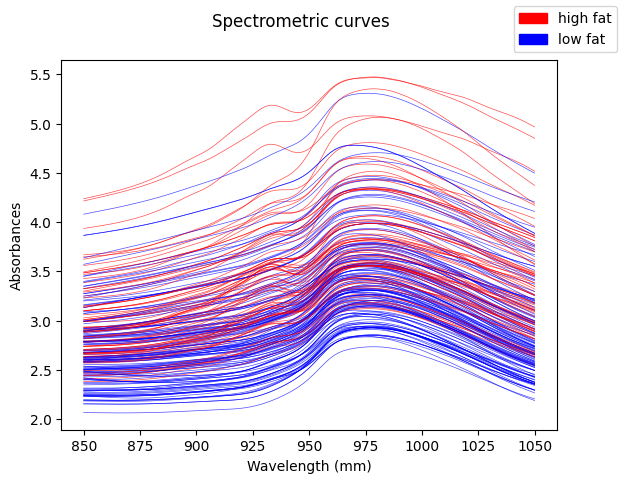

In [10]:
fd = df_func.iloc[:, 0].values
fat = df_obs["fat"].values

low_fat = fat < 20
labels = np.full(fd.n_samples, "high fat")
labels[low_fat] = "low fat"
colors = {
    "high fat": "red",
    "low fat": "blue",
}

fig = fd.plot(
    group=labels,
    group_colors=colors,
    linewidth=0.5,
    alpha=0.7,
    legend=True,
)

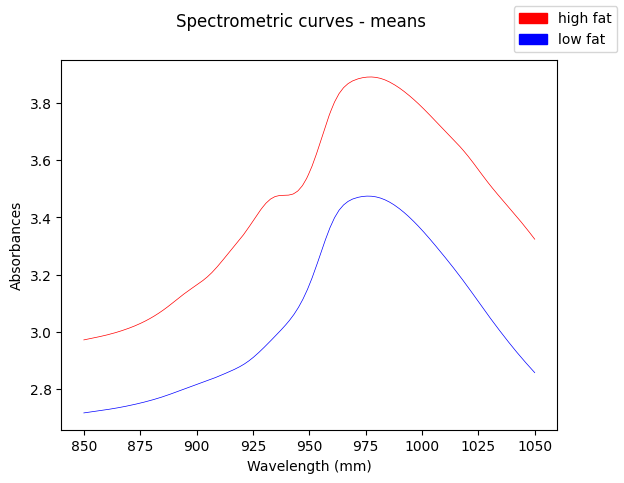

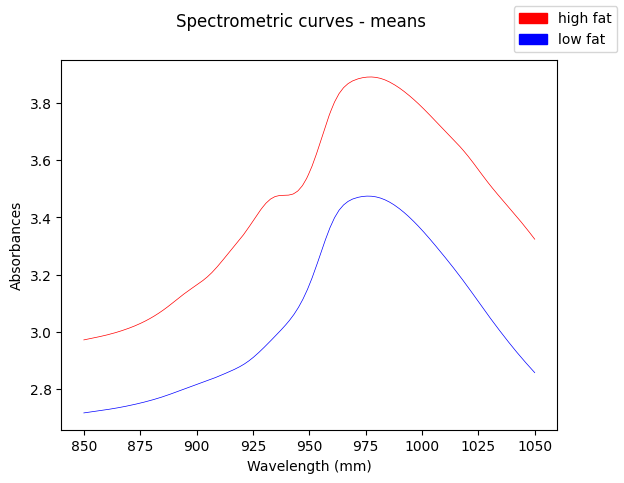

In [9]:
mean_low = skfda.exploratory.stats.mean(fd[low_fat])
mean_high = skfda.exploratory.stats.mean(fd[~low_fat])

means = mean_high.concatenate(mean_low)

means.dataset_name = f"{fd.dataset_name} - means"
means.plot(
    group=["high fat", "low fat"],
    group_colors=colors,
    linewidth=0.5,
    legend=True,
)

### Process Data for FNN

In [33]:
fda_data, obs_data = skfda.datasets.fetch_tecator(return_X_y=True, as_frame=False)
data = np.concatenate(
    (
        fda_data.data_matrix,
        fda_data.derivative().data_matrix,
        fda_data.derivative().derivative().data_matrix,
    ),
    axis=2,
)

X_train, X_val, obs_data_train, obs_data_val = train_test_split(
    data, obs_data, test_size=0.2, random_state=42
)
y_train = obs_data_train[:,0]
y_val = obs_data_val[:,0]

### Build Model

In [34]:
import tensorflow as tf

hidden_layers = [
    FunDLnBlockConfig(
        name="01_relu_dropout_16",
        units=16,
        activation="relu",
        dropout_rate=None,
    ),
    FunDLnBlockConfig(
        name="02_relu_dropout_16",
        units=32,
        activation="relu",
        dropout_rate=None,
    ),
    FunDLnBlockConfig(
        name="03_relu_dropout_16",
        units=16,
        activation="relu",
        dropout_rate=None,
    ),
    FunDLnBlockConfig(
        name="04_relu_16",
        units=8,
        activation="relu",
        add_dropout=False,
        dropout_rate=None,
    ),
]
input_shape = 100
output_size = 2
model = FunDL(
    objective=FunDLObjective("classification"),
    input_shape=input_shape,
    hidden_layers=hidden_layers,
    output_size=output_size,
)
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001, decay = 0),
    loss="mse", 
    metrics=["mean_squared_error"]

)
_ = model.summary(line_length=100, show_trainable=True)

Model: "<property object at 0x293c954a0>"
_______________________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        Trainable  
 input (InputLayer)                          [(None, 100)]                           0              Y          
                                                                                                               
 01_relu_dropout_16 (DenseDropoutBlock)      (None, 16)                              1616           Y          
                                                                                                               
 02_relu_dropout_16 (DenseDropoutBlock)      (None, 32)                              544            Y          
                                                                                                               
 03_relu_dropout_16 (DenseDropoutBlock)      (None, 16)       

In [35]:
model.fit(X_train, y_train)

TypeError: in user code:

    File "/Users/denis/miniforge3/envs/brawler/lib/python3.9/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/Users/denis/miniforge3/envs/brawler/lib/python3.9/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/denis/miniforge3/envs/brawler/lib/python3.9/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/Users/denis/miniforge3/envs/brawler/lib/python3.9/site-packages/keras/engine/training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "/Users/denis/miniforge3/envs/brawler/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/denis/Repos/research/func-deep-learning/notebooks/../fundl/model.py", line 100, in call
        return __model(inputs)

    TypeError: Exception encountered when calling layer "fun_dl_12" (type FunDL).
    
    can only concatenate str (not "property") to str
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, 100, 3), dtype=float32)
      • training=True


In [12]:
df_func.data_matrix.shape

(215, 100, 1)

In [18]:
df_func.derivative().derivative().data_matrix

array([[[ 1.65392206e-05],
        [ 1.77643480e-05],
        [ 2.38899853e-05],
        ...,
        [-2.08271667e-05],
        [-9.80101960e-06],
        [ 9.80101960e-06]],

       [[-2.14397304e-05],
        [-3.06281863e-06],
        [ 1.59266569e-05],
        ...,
        [-2.29711397e-04],
        [-2.04596284e-04],
        [-1.72742970e-04]],

       [[-1.40889657e-05],
        [-6.12563725e-07],
        [ 1.34764020e-05],
        ...,
        [ 1.28025819e-04],
        [ 1.10261471e-04],
        [ 9.55599411e-05]],

       ...,

       [[ 3.49161323e-05],
        [ 3.36910049e-05],
        [ 3.36910049e-05],
        ...,
        [-1.65392206e-04],
        [-1.38439402e-04],
        [-1.01685578e-04]],

       [[ 6.12563725e-05],
        [ 4.16543333e-05],
        [ 3.24658774e-05],
        ...,
        [-2.60339583e-04],
        [-2.34611907e-04],
        [-2.06433975e-04]],

       [[ 2.63402402e-05],
        [ 4.22668970e-05],
        [ 6.18689362e-05],
        ...,
        